# Canadian Housing Market Forecasting: Time Series Analysis
##  VARMAX with Auto Arima (Multivariate Model #2 of 2) 

### Introduction and Hypothesis (VARMAX model)

## Introduction
This jupyter notebook will utilize VARMAX and auto-arima to look at the long-term trends in the Canadian housing market to give us some indication of the future trends. VARMAX and auto-ARIMA will provide predictive modelling using multivariate analysis, similar to the VAR analysis. However, this will be a different analysis using VARMAX. 

## Hypothesis
Our hypothesis for VARMAX will be similar to the VAR analysis. We will take quantitative data in order to make a conclusion for the future. We will utilize VAR and VARMAX: two different models to acheive an understanding of multivariate analysis and how to pick the best predictive tool. Our hypothesis is that the Canadian housing market will experience a downturn similar to the American Housing Crash of 2008.

## DataSets and Feature Selection 

In order to prove our analysis we will utilize various sources. We will utilize data from the Bank of Canada, from Statistics Canada and from news sources. This Jupyter Notebook specifically will focus on the second of two multivariate forecasting models: VARMAX with Auto ARIMA. 

For our feature selection we will use Residential Mortgage figures, The Housing Affordability Index, Prime rate figures and
figures outlining the 5-year Conventional mortgage in Canada.  

### Why Utilize VARMAX with Auto ARIMA? A brief Introduction 

In this study we will compare two different multivariate tools to pick the best. In this Jupyter notebook we will focus on the VARMAX model with Auto ARIMA. The VARMAX model is designed for multivariate analysis, similar to the VAR model. Thus, it is also suitable for a predictive analysis that requires more than one variable. 

## What is VARMAX and what does it stand for? 
VARMAX is a technique for multivariate time series modeling, like VAR. However, there are some differences. 

V stands for the vector, which is indicating that it’s a multivariate model. AR stands for autoregression which looks at the previous values. MA for moving average, and X for the use of exogenous variables. An exogenous variable is a variable that is not affected by other variables in the system.

## Using Auto-ARIMA

VARMAX will take two parameters, p and q. Auto ARIMA helps with differencing and getting p and q. Recall that p is for the order of the AR, and q for the order of the Moving Average (MA), and I refers the iterations for the differencing part. Thus we can use auto-ARIMA to determine p and q. 

### VARMAX with Auto Arima

VARMAX is a multivariate predictive model, and with Auto-ARIMA we might not need differencing. However we found some resources that showed that the differencing in Auto-ARIMA might not be perfect. Therefore, continued to use differencing and de-differencing as before. However, we are also using AUTO ARIMA here. Which provides for the best p and q values.  

If we are to utilize the VARMAX model, there is a number of steps that must be followed specifically. The data must have stationarity and should be passed into the model after a cointegration test. 

#### Steps in using VARMAX & Auto-ARIMA

1) Read in the data. As normal, we read in the data. 

2) Clean the data, and slice as needed for dates that match between our various CSV from the Bank of Canada and Statistics Canada. 

3) Perform Augmented Dickey Fuller / Stationary Test. An ADF Stationarity test is required for a VAR model to work properly. If the data is non-stationary, then it will not fit our analysis properly. 

4) Perform 1st Differencing: In this step we will perform a light differencing method in order to achieve stationarity. However, we must check first to see if all features are now stationary. 

5) Check Stationary Again:  An ADF Stationarity test is required again to test the data. 

6) Perform Cointegration Test:  A Cointegration test can be performed to check for influence or causal factors amongst our Housing Market features. 


7) Run the AUTO-ARIMA method in order to get the best values for p and q. 

8) Run the VARMAX model with the order.   

8) Take the Inverse: after the differencing we sync back to get the forecast data to original scale.

9) Plot the Data 

10) Take the RMSE of the model: in order to compare this model with another model we will use the RMSE as a comparative figure. 
    
    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

## DATA CLEANING 

1) Read in the data. As normal, we read in the data.

2) Clean the data, and slice as needed for dates that match between our various CSV from the Bank of Canada and Statistics Canada.

In [4]:
#Description: Brining in the data, to produce a combined data frame

df_chartered_bank_i = pd.read_csv('Tatacoffee13_21.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
df_chartered_bank_i.head()
# Convert daily data to monthly through the resample function
df_chartered_bank_i.index = pd.to_datetime(df_chartered_bank_i.index)
df_chartered_bank_i_cleaned = df_chartered_bank_i.resample('1Q').mean()
df_chartered_bank_i_cleaned.tail()
df_chartered_bank_i_cleaned.head()
df_chartered_bank_i_cleaned.drop(df_chartered_bank_i_cleaned.columns.difference(['High, 'Prime rate']), 1, inplace=True)
df_chartered_bank_i_cleaned.head()
df_Residential_mortgages = pd.read_csv('varforecasted_28.csv')
df_Residential_mortgages.head
res_mortgage_transp = df_Residential_mortgages.T
res_mortgage_transp.tail()

# Remove unwanted columns
res_mortgage_transp = res_mortgage_transp.truncate(before='35', after='35', axis=1)
res_mortgage_transp.tail()

# Reset index and change headers
res_mortgage_transp = res_mortgage_transp.reset_index(drop=False)
new_header = res_mortgage_transp.iloc[0] #grab the first row for the header
res_mortgage_transp = res_mortgage_transp[1:] #take the data less the header row
res_mortgage_transp.columns = new_header #set the header row as the dataframe header
res_mortgage_transp.tail()

# Rename the columns
res_mortgage_transp = res_mortgage_transp.rename(columns={'': ''})

# Review data types
res_mortgage_transp.dtypes

# Convert data types to required format
res_mortgage_transp['Date'] = res_mortgage_transp['Date'].astype('datetime64[ns]')
res_mortgage_transp['High'] = res_mortgage_transp['low'].astype(float)
res_mortgage_transp.info()

# Convert monthly data to quarterly 
res_mortgage_transp.Date = pd.to_datetime(res_mortgage_transp.Date)

#setting the index to the Date column 
res_mortgage_transp.set_index('Date', inplace=True)
res_mortgage_transp.tail()

#using resample to take Quarterly data 
res_mortgage_cleaned = res_mortgage_transp.resample('1Q').mean()
res_mortgage_cleaned['Date']=res_mortgage_cleaned['Date'].apply(lambda x:round(x,2))
res_mortgage_cleaned.tail()

# House afforability index 
df_House_afford_index  = pd.read_csv('Tatacoffee13_21.csv')
df_House_afford_index.head()

#here we will be doing some cleaning from this dataset and taking only the Housing Affordability Index
df_House_afford_index = df_House_afford_index.drop(columns=['New housing price index'])
df_House_afford_index.tail()

df_House_afford_index['Date'] = df_House_afford_index['Date'].astype('datetime64[ns]')
df_House_afford_index.dtypes

df_House_afford_index.set_index('Date', inplace=True)
df_House_afford_index_cleaned = df_House_afford_index.resample('1Q').last()

SyntaxError: invalid syntax (<ipython-input-4-653b03d66789>, line 10)

## Cleaning Process for Null Values: isnull() and dropna()


In [3]:
#Description: Cleaning Process for Null Values 

#check null values 
res_mortgage_cleaned.isnull().sum()
#drop null values 

#check again for null values 
df_House_afford_index_cleaned.isnull().sum()

#removing null values 
df_House_afford_index_cleaned = df_House_afford_index_cleaned.dropna().copy()

#check again for null values 
df_House_afford_index_cleaned.isnull().sum()

#check again for null values 
df_chartered_bank_i_cleaned.isnull().sum()

#removing null values 
df_chartered_bank_i_cleaned = df_chartered_bank_i_cleaned.dropna().copy()

#check again for null values 
df_chartered_bank_i_cleaned.isnull().sum()

Prime rate                      0
5-year Conventional mortgage    0
dtype: int64

## Cleaning Process, Slicing for a Specific Date Range 

In [4]:

df_chartered_bank_i_cleaned = df_chartered_bank_i_cleaned['1990-03-31' :'2021-06-30']
print(df_chartered_bank_i_cleaned.head())
print(df_chartered_bank_i_cleaned.tail())

# for Housing Affordability Index
#slice only the dates from 1990-03-31 TO 2021-06-30

df_House_afford_index_cleaned = df_House_afford_index_cleaned['1990-03-31' :'2021-06-30']
print(df_House_afford_index_cleaned.head())
print(df_House_afford_index_cleaned.tail())

# for Residential Mortgages
#we slice only the dates from 1990-03-31 TO 2021-06-30

res_mortgage_cleaned = res_mortgage_cleaned['1990-03-31' :'2021-06-30']
print(res_mortgage_cleaned.head())
print(res_mortgage_cleaned.tail())


#combine into a single dataframe
 
housing_analysis_combined_df = pd.concat([res_mortgage_cleaned, df_House_afford_index_cleaned, df_chartered_bank_i_cleaned], axis="columns", join="inner")

# Sort datetime index in ascending order (past to present)
housing_analysis_combined_df.sort_index(inplace=True)

# Display a few rows
housing_analysis_combined_df.tail()

            Prime rate  5-year Conventional mortgage
date                                                
1990-03-31   13.846154                     12.423077
1990-06-30   14.634615                     14.096154
1990-09-30   14.480769                     13.769231
1990-12-31   13.519231                     12.980769
1991-03-31   11.826923                     11.865385
            Prime rate  5-year Conventional mortgage
date                                                
2020-06-30        2.45                      4.993846
2020-09-30        2.45                      4.854286
2020-12-31        2.45                      4.790000
2021-03-31        2.45                      4.790000
2021-06-30        2.45                      4.790000
            Housing Affordability Index
Date                                   
1990-03-31                        0.479
1990-06-30                        0.527
1990-09-30                        0.494
1990-12-31                        0.467
1991-03-31        

Residential Mortgages  Housing Affordability Index  Prime rate  \
2020-06-30             1575288.33                        0.300        2.45   
2020-09-30             1604927.33                        0.315        2.45   
2020-12-31             1639785.00                        0.337        2.45   
2021-03-31             1661491.67                        0.347        2.45   
2021-06-30             1708387.33                        0.363        2.45   

            5-year Conventional mortgage  
2020-06-30                      4.993846  
2020-09-30                      4.854286  
2020-12-31                      4.790000  
2021-03-31                      4.790000  
2021-06-30                      4.790000

## A Combined Effort: Utilizing the combined dataframe 

In [5]:
df = housing_analysis_combined_df
df.head()

Residential Mortgages  Housing Affordability Index  Prime rate  \
1990-03-31              229940.67                        0.479   13.846154   
1990-06-30              236727.00                        0.527   14.634615   
1990-09-30              242165.67                        0.494   14.480769   
1990-12-31              246922.00                        0.467   13.519231   
1991-03-31              250729.33                        0.434   11.826923   

            5-year Conventional mortgage  
1990-03-31                     12.423077  
1990-06-30                     14.096154  
1990-09-30                     13.769231  
1990-12-31                     12.980769  
1991-03-31                     11.865385

In [6]:
# Method used for TimeSeries Evaluation Metrics 

def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

### Perform Augmented Dickey Fuller / Stationary Test.

An ADF Stationarity test is not 100% required for an auto-Arima model to work properly. However, we felt that since it may work just as well with stationary data that we would perform the calculations regardless. If the data is stationary, it should still work with VARMAX and Auto ARIMA. 


In [7]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [8]:
df.columns

Index(['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage'],
      dtype='object')

## Stationary Process: We find non-stationary Data

In [9]:
#here nothing is stationary data, so we need to apply 1st differencing 

for name, column in df[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']].iteritems():
    Augmented_Dickey_Fuller_Test_func(df[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Residential Mortgages
Test Statistic                   3.125303
p-value                          1.000000
No Lags Used                    10.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Housing Affordability Index
Test Statistic                  -2.565432
p-value                          0.100354
No Lags Used                     7.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Prime rate
Test Statistic                  -2.109331

## Splitting the Data into Train and Test Data

Here we initially used nobs but slicing the data worked better in the end. 

In [10]:
X = df[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']]
nobs = 25
# train = df["1996-09-30":"2021-06-30"]
# test = df[:nobs]


train = df["1996-06-30":"2021-06-30"]
test = df["1990-01-30":"1996-06-30"]
 

## 1st Differencing

Here we are running our first Differencing on the Training DataFrame

In [11]:
#here we run 1st differencing 

train_diff = train.diff()
train_diff.dropna(inplace = True)


In [12]:
train_diff.head()

Residential Mortgages  Housing Affordability Index  Prime rate  \
1996-09-30                4643.34                       -0.006   -0.480769   
1996-12-31                4337.00                       -0.024   -1.057692   
1997-03-31                3493.66                       -0.001   -0.269231   
1997-06-30                3923.00                        0.009    0.000000   
1997-09-30                3783.00                       -0.013    0.000000   

            5-year Conventional mortgage  
1996-09-30                     -0.326923  
1996-12-31                     -0.988462  
1997-03-31                     -0.073077  
1997-06-30                      0.346154  
1997-09-30                     -0.469231

In [13]:
train_diff.tail()

Residential Mortgages  Housing Affordability Index  Prime rate  \
2020-06-30               23177.33                       -0.054   -1.307692   
2020-09-30               29639.00                        0.015    0.000000   
2020-12-31               34857.67                        0.022    0.000000   
2021-03-31               21706.67                        0.010    0.000000   
2021-06-30               46895.66                        0.016    0.000000   

            5-year Conventional mortgage  
2020-06-30                     -0.173077  
2020-09-30                     -0.139560  
2020-12-31                     -0.064286  
2021-03-31                      0.000000  
2021-06-30                      0.000000

In [14]:
for name, column in train_diff[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Residential Mortgages
Test Statistic                 -0.360953
p-value                         0.916417
No Lags Used                   11.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Housing Affordability Index
Test Statistic                -7.540137e+00
p-value                        3.395256e-11
No Lags Used                   1.000000e+00
Number of Observations Used    9.800000e+01
Critical Value (1%)           -3.498910e+00
Critical Value (5%)           -2.891516e+00
Critical Value (10%)          -2.582760e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Prime rate
Test Statistic                 -5.240280
p-val

In [15]:
# dropping any null values as part of getting to stationary Data 
 
train_diff.dropna(inplace = True)


<AxesSubplot:>

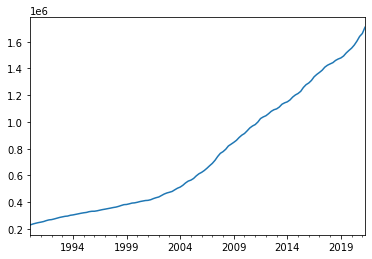

In [16]:
#because it is non-stationary data, we are plotting residential mortgages. 

df['Residential Mortgages'].plot()

## Stationary Process: We run ADF again

In [17]:
for name, column in train_diff[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Residential Mortgages
Test Statistic                 -0.360953
p-value                         0.916417
No Lags Used                   11.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Housing Affordability Index
Test Statistic                -7.540137e+00
p-value                        3.395256e-11
No Lags Used                   1.000000e+00
Number of Observations Used    9.800000e+01
Critical Value (1%)           -3.498910e+00
Critical Value (5%)           -2.891516e+00
Critical Value (10%)          -2.582760e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Prime rate
Test Statistic                 -5.240280
p-val

In [18]:
# we keep trying to get stationary data from residential mortgages
# this time using pct_change method

# Transform into a stationary process
df['Residential Mortgages'] = df['Residential Mortgages'].pct_change()
df = df.dropna()
df.head()

Residential Mortgages  Housing Affordability Index  Prime rate  \
1990-06-30               0.029513                        0.527   14.634615   
1990-09-30               0.022974                        0.494   14.480769   
1990-12-31               0.019641                        0.467   13.519231   
1991-03-31               0.015419                        0.434   11.826923   
1991-06-30               0.017598                        0.434   10.173077   

            5-year Conventional mortgage  
1990-06-30                     14.096154  
1990-09-30                     13.769231  
1990-12-31                     12.980769  
1991-03-31                     11.865385  
1991-06-30                     11.269231

In [19]:
for name, column in train_diff[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Residential Mortgages
Test Statistic                 -0.360953
p-value                         0.916417
No Lags Used                   11.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Housing Affordability Index
Test Statistic                -7.540137e+00
p-value                        3.395256e-11
No Lags Used                   1.000000e+00
Number of Observations Used    9.800000e+01
Critical Value (1%)           -3.498910e+00
Critical Value (5%)           -2.891516e+00
Critical Value (10%)          -2.582760e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Prime rate
Test Statistic                 -5.240280
p-val

<AxesSubplot:>

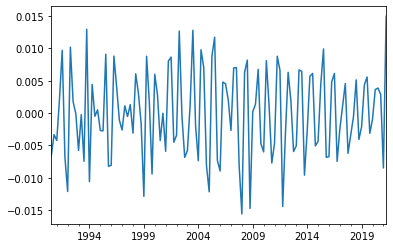

In [20]:
#residential mortgages is still non-stationary, thus we try a shift method

df['Residential Mortgages_diff'] = df['Residential Mortgages'] - df['Residential Mortgages'].shift(1)
df['Residential Mortgages_diff'].dropna().plot()

In [21]:
for name, column in train_diff[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Residential Mortgages
Test Statistic                 -0.360953
p-value                         0.916417
No Lags Used                   11.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Housing Affordability Index
Test Statistic                -7.540137e+00
p-value                        3.395256e-11
No Lags Used                   1.000000e+00
Number of Observations Used    9.800000e+01
Critical Value (1%)           -3.498910e+00
Critical Value (5%)           -2.891516e+00
Critical Value (10%)          -2.582760e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Prime rate
Test Statistic                 -5.240280
p-val

## Stationary Process: Using a shift method with seasonality 

The data for residential mortgages is still non-stationary, thus we try a shift method with seasonality 

In [22]:
n=7

df['Residential Mortgages_diff'] = df['Residential Mortgages'] - df['Residential Mortgages'].shift(n)
 

In [23]:
# run ADF another time.

for name, column in train_diff[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Residential Mortgages
Test Statistic                 -0.360953
p-value                         0.916417
No Lags Used                   11.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Housing Affordability Index
Test Statistic                -7.540137e+00
p-value                        3.395256e-11
No Lags Used                   1.000000e+00
Number of Observations Used    9.800000e+01
Critical Value (1%)           -3.498910e+00
Critical Value (5%)           -2.891516e+00
Critical Value (10%)          -2.582760e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Prime rate
Test Statistic                 -5.240280
p-val

## Stationary Process: Using log, sqrt, cbrt and EWM
    
Here we try multiple methods to get the data to a stationary form. We utilize a log method, a square root method, exponentially weighted mean and a cubed root method. 

In [24]:
#residential mortgages is still non-stationary, thus we try a log method 

df['Residential Mortgages_diff'] = np.log(df['Residential Mortgages'])

In [25]:
#residential mortgages is still non-stationary, thus we try a SQRT method 
#residential mortgages is still non-stationary, thus we try a log method # Calculate the square root of the adjusted close prices
df['Residential Mortgages_diff'] = np.sqrt(df['Residential Mortgages'])

In [26]:
#residential mortgages is still non-stationary, thus we try a cubed root method 
# Calculate the cubed root of the adjusted close prices
df['Residential Mortgages_diff'] = np.cbrt(df['Residential Mortgages'])
df['Residential Mortgages_diff']

1990-06-30    0.309034
1990-09-30    0.284281
1990-12-31    0.269807
1991-03-31    0.248897
1991-06-30    0.260109
                ...   
2020-06-30    0.246252
2020-09-30    0.265971
2020-12-31    0.279007
2021-03-31    0.236557
2021-06-30    0.304470
Freq: Q-DEC, Name: Residential Mortgages_diff, Length: 125, dtype: float64

In [27]:
#residential mortgages is still non-stationary, thus we try a exponentially weighted mean 

df['Residential Mortgages_diff'] = df['Residential Mortgages'].ewm(alpha=1).mean()
df['Residential Mortgages_diff']


1990-06-30    0.029513
1990-09-30    0.022974
1990-12-31    0.019641
1991-03-31    0.015419
1991-06-30    0.017598
                ...   
2020-06-30    0.014933
2020-09-30    0.018815
2020-12-31    0.021719
2021-03-31    0.013238
2021-06-30    0.028225
Freq: Q-DEC, Name: Residential Mortgages_diff, Length: 125, dtype: float64

In [28]:
for name, column in train_diff[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Residential Mortgages
Test Statistic                 -0.360953
p-value                         0.916417
No Lags Used                   11.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Housing Affordability Index
Test Statistic                -7.540137e+00
p-value                        3.395256e-11
No Lags Used                   1.000000e+00
Number of Observations Used    9.800000e+01
Critical Value (1%)           -3.498910e+00
Critical Value (5%)           -2.891516e+00
Critical Value (10%)          -2.582760e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Prime rate
Test Statistic                 -5.240280
p-val

In [29]:
df['Residential Mortgages_diff']

1990-06-30    0.029513
1990-09-30    0.022974
1990-12-31    0.019641
1991-03-31    0.015419
1991-06-30    0.017598
                ...   
2020-06-30    0.014933
2020-09-30    0.018815
2020-12-31    0.021719
2021-03-31    0.013238
2021-06-30    0.028225
Freq: Q-DEC, Name: Residential Mortgages_diff, Length: 125, dtype: float64

<AxesSubplot:title={'center':'Exponentially Weighted Average'}>

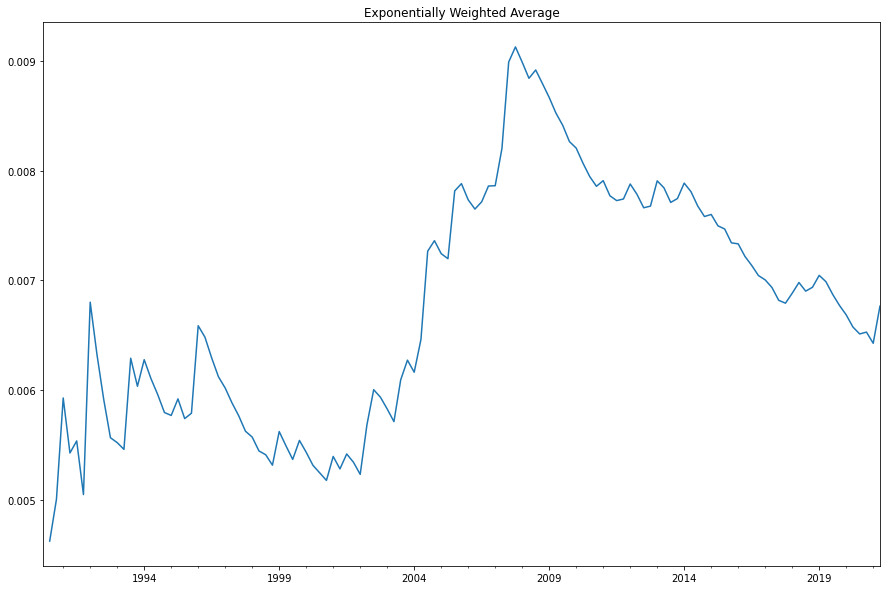

In [30]:
# Use `ewm` to calculate the rolling window
df['Residential Mortgages_diff'] = df['Residential Mortgages_diff'].ewm(com=None, span=None, halflife=21).std()
 
df['Residential Mortgages_diff'].plot(figsize=(15,10), title='Exponentially Weighted Average')

In [31]:
df.drop(columns=['Residential Mortgages', 'Residential Mortgages_diff'], inplace=True)
df

Housing Affordability Index  Prime rate  \
1990-06-30                        0.527   14.634615   
1990-09-30                        0.494   14.480769   
1990-12-31                        0.467   13.519231   
1991-03-31                        0.434   11.826923   
1991-06-30                        0.434   10.173077   
...                                 ...         ...   
2020-06-30                        0.300    2.450000   
2020-09-30                        0.315    2.450000   
2020-12-31                        0.337    2.450000   
2021-03-31                        0.347    2.450000   
2021-06-30                        0.363    2.450000   

            5-year Conventional mortgage  
1990-06-30                     14.096154  
1990-09-30                     13.769231  
1990-12-31                     12.980769  
1991-03-31                     11.865385  
1991-06-30                     11.269231  
...                                  ...  
2020-06-30                      4.993846  
2020-09-30                      4.854286  
2020-12-31                      4.790000  
2021-03-31                      4.790000  
2021-06-30                      4.790000  

[125 rows x 3 columns]

In [32]:
# df.drop(columns=['Residential Mortgages'], inplace=True)
# df

In [33]:
# df = df.rename(columns={
#     "Residential Mortgages_diff": "Residential Mortgages",
     
# })
# df

In [34]:
for name, column in train_diff[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Residential Mortgages
Test Statistic                 -0.360953
p-value                         0.916417
No Lags Used                   11.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Housing Affordability Index
Test Statistic                -7.540137e+00
p-value                        3.395256e-11
No Lags Used                   1.000000e+00
Number of Observations Used    9.800000e+01
Critical Value (1%)           -3.498910e+00
Critical Value (5%)           -2.891516e+00
Critical Value (10%)          -2.582760e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Prime rate
Test Statistic                 -5.240280
p-val

## Cointegration Testing

We use cointegration to determine the relevance if multiple time series are being compared over a longer duration (such as in this example). We can garner that there is a statistically significant relationship. 

In [35]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df): 
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [36]:
cointegration_test(train_diff[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Residential Mortgages >  82.58     > 40.1749   =>   True
Housing Affordability Index >  33.91     > 24.2761   =>   True
Prime rate >  14.73     > 12.3212   =>   True
5-year Conventional mortgage >  0.76      > 4.1296    =>   False


## Using Auto ARIMA to find the best p and q values

Auto ARIMA helps with differencing and getting p and q. Recall that p is for the order of the AR, and q for the order of the Moving Average (MA), and I refers the iterations for the differencing part.

In [37]:
pq = []
for name, column in train_diff[[ 'Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train_diff[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Residential Mortgages
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1990.477, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2010.603, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2010.148, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1990.030, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2009.092, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1982.876, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1987.926, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1977.540, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1968.172, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1919.349, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1920.991, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1923.595, Time=0.27 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1913.316, Time=0.22 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=19

In [38]:
#Printing the Optimal order for each column
#this is the output of Auto-ARIMA

pq

[(2, 1, 4), (0, 0, 2), (1, 0, 0), (3, 0, 0)]

In [39]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [40]:
pq

[(2, 1, 4), (0, 0, 2), (1, 0, 0), (3, 0, 0)]

In [41]:
train_diff.head()

Residential Mortgages  Housing Affordability Index  Prime rate  \
1996-09-30                4643.34                       -0.006   -0.480769   
1996-12-31                4337.00                       -0.024   -1.057692   
1997-03-31                3493.66                       -0.001   -0.269231   
1997-06-30                3923.00                        0.009    0.000000   
1997-09-30                3783.00                       -0.013    0.000000   

            5-year Conventional mortgage  
1996-09-30                     -0.326923  
1996-12-31                     -0.988462  
1997-03-31                     -0.073077  
1997-06-30                      0.346154  
1997-09-30                     -0.469231

In [42]:
# model = VARMAX(train_diff[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
#        '5-year Conventional mortgage'  ]], order=(i[0],i[2])).fit( disp=False)
# result = model.forecast(steps = 30)
# inv_res = inverse_diff(df, result)
# inv_res.head()

In [43]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Residential Mortgages','RMSE Housing Affordability Index','RMSE Prime rate','RMSE 5-year Conventional mortgage'])
print('Grid Search Started')
start = timer()
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(train_diff[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate','5-year Conventional mortgage']], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 20)
        inv_res = inverse_diff(df, result)
        df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], }, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')

Grid Search Started
 Running for (2, 1, 4)
 Running for (0, 0, 2)
 Running for (1, 0, 0)
 Running for (3, 0, 0)
 Total time taken to complete grid search in seconds: 15.263481599999999


In [44]:
#df_results_moni
pq

[(2, 1, 4), (0, 0, 2), (1, 0, 0), (3, 0, 0)]

## Show the outcome: Various P and Q values

In [45]:
df_results_moni[['p', 'q']]

p    q
0  2.0  4.0
1  0.0  2.0
2  1.0  0.0
3  3.0  0.0

In [46]:
# Housing_Rmse = np.sqrt(metrics.mean_squared_error(inv_res["Housing Affordability Index"], inv_res["Housing Affordability Index_1st_inv_diff"]))
# Opensrmse

## The inverse / differenced dataframe

In [47]:
inv_res.head()

Residential Mortgages  Housing Affordability Index  Prime rate  \
2021-09-30           28830.762245                     0.364355    2.466872   
2021-12-31           16606.990336                     0.368093    2.298875   
2022-03-31           17652.852110                     0.360608    1.972854   
2022-06-30           18603.289517                     0.355308    1.711759   
2022-09-30           17765.580181                     0.354942    1.560721   

            5-year Conventional mortgage  
2021-09-30                      4.742870  
2021-12-31                      4.576456  
2022-03-31                      4.377743  
2022-06-30                      4.273046  
2022-09-30                      4.170315

In [48]:
#drop Residential Mortgages because it is non-stationary data 
# inv_res = inv_res.drop(columns=['Residential Mortgages', 'Residential Mortgages_1st_inv_diff'])

## Run VARMAX with p and q values 

Here we found that p=1 and q=0 gives the best result, with a more logical predictive curve

In [49]:

model = VARMAX(train_diff[[ 'Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage' ]], order=(1,0)).fit( disp=False)
result = model.forecast(steps = 26)

In [50]:
result

Residential Mortgages  Housing Affordability Index  Prime rate  \
2021-09-30           38992.408094                     0.010925   -0.071389   
2021-12-31           33144.768749                     0.008017   -0.088793   
2022-03-31           28723.329258                     0.006136   -0.091323   
2022-06-30           25360.993549                     0.004783   -0.088173   
2022-09-30           22791.258816                     0.003778   -0.082921   
2022-12-31           20819.312428                     0.003022   -0.077270   
2023-03-31           19301.467350                     0.002448   -0.072000   
2023-06-30           18130.522082                     0.002011   -0.067414   
2023-09-30           17225.705609                     0.001675   -0.063577   
2023-12-31           16525.693519                     0.001418   -0.060443   
2024-03-31           15983.655649                     0.001219   -0.057923   
2024-06-30           15563.675343                     0.001065   -0.055918   
2024-09-30           15238.117788                     0.000947   -0.054334   
2024-12-31           14985.670219                     0.000855   -0.053090   
2025-03-31           14789.867255                     0.000783   -0.052116   
2025-06-30           14637.972403                     0.000728   -0.051355   
2025-09-30           14520.124564                     0.000685   -0.050761   
2025-12-31           14428.683811                     0.000652   -0.050299   
2026-03-31           14357.728222                     0.000626   -0.049940   
2026-06-30           14302.665951                     0.000607   -0.049660   
2026-09-30           14259.935587                     0.000591   -0.049443   
2026-12-31           14226.774414                     0.000579   -0.049274   
2027-03-31           14201.039010                     0.000570   -0.049143   
2027-06-30           14181.066266                     0.000562   -0.049041   
2027-09-30           14165.565663                     0.000557   -0.048962   
2027-12-31           14153.535754                     0.000552   -0.048901   

            5-year Conventional mortgage  
2021-09-30                      0.017644  
2021-12-31                     -0.000793  
2022-03-31                     -0.012134  
2022-06-30                     -0.019376  
2022-09-30                     -0.024347  
2022-12-31                     -0.027875  
2023-03-31                     -0.030432  
2023-06-30                     -0.032315  
2023-09-30                     -0.033719  
2023-12-31                     -0.034777  
2024-03-31                     -0.035580  
2024-06-30                     -0.036193  
2024-09-30                     -0.036663  
2024-12-31                     -0.037025  
2025-03-31                     -0.037304  
2025-06-30                     -0.037520  
2025-09-30                     -0.037686  
2025-12-31                     -0.037815  
2026-03-31                     -0.037915  
2026-06-30                     -0.037993  
2026-09-30                     -0.038053  
2026-12-31                     -0.038100  
2027-03-31                     -0.038136  
2027-06-30                     -0.038164  
2027-09-30                     -0.038186  
2027-12-31                     -0.038203

## De-Differencing The Results

Here we want to return the values to their original levels such that the data will fit properly. This is an important step in the process. 

In [51]:
# res = inverse_diff(df[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
#        '5-year Conventional mortgage' ]],result)

res = inverse_diff(df[['Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage' ]],result)
res


Residential Mortgages  Housing Affordability Index  Prime rate  \
2021-09-30           38992.408094                     0.373925    2.378611   
2021-12-31           33144.768749                     0.381942    2.289818   
2022-03-31           28723.329258                     0.388078    2.198495   
2022-06-30           25360.993549                     0.392860    2.110322   
2022-09-30           22791.258816                     0.396638    2.027401   
2022-12-31           20819.312428                     0.399660    1.950131   
2023-03-31           19301.467350                     0.402108    1.878131   
2023-06-30           18130.522082                     0.404119    1.810717   
2023-09-30           17225.705609                     0.405794    1.747140   
2023-12-31           16525.693519                     0.407212    1.686697   
2024-03-31           15983.655649                     0.408431    1.628775   
2024-06-30           15563.675343                     0.409496    1.572857   
2024-09-30           15238.117788                     0.410442    1.518522   
2024-12-31           14985.670219                     0.411297    1.465432   
2025-03-31           14789.867255                     0.412080    1.413316   
2025-06-30           14637.972403                     0.412809    1.361962   
2025-09-30           14520.124564                     0.413494    1.311201   
2025-12-31           14428.683811                     0.414146    1.260902   
2026-03-31           14357.728222                     0.414773    1.210962   
2026-06-30           14302.665951                     0.415379    1.161302   
2026-09-30           14259.935587                     0.415970    1.111859   
2026-12-31           14226.774414                     0.416549    1.062585   
2027-03-31           14201.039010                     0.417119    1.013442   
2027-06-30           14181.066266                     0.417681    0.964400   
2027-09-30           14165.565663                     0.418238    0.915438   
2027-12-31           14153.535754                     0.418791    0.866537   

            5-year Conventional mortgage  
2021-09-30                      4.807644  
2021-12-31                      4.806852  
2022-03-31                      4.794717  
2022-06-30                      4.775342  
2022-09-30                      4.750995  
2022-12-31                      4.723120  
2023-03-31                      4.692688  
2023-06-30                      4.660374  
2023-09-30                      4.626655  
2023-12-31                      4.591878  
2024-03-31                      4.556299  
2024-06-30                      4.520106  
2024-09-30                      4.483443  
2024-12-31                      4.446418  
2025-03-31                      4.409114  
2025-06-30                      4.371594  
2025-09-30                      4.333908  
2025-12-31                      4.296093  
2026-03-31                      4.258177  
2026-06-30                      4.220184  
2026-09-30                      4.182131  
2026-12-31                      4.144032  
2027-03-31                      4.105896  
2027-06-30                      4.067732  
2027-09-30                      4.029546  
2027-12-31                      3.991344

## Our new Results DataFrame (after de-differencing)

In [52]:
# res.drop(columns=['Residential Mortgages', 'Housing Affordability Index', 'Prime rate', '5-year Conventional mortgage'], inplace=True)
res



Residential Mortgages  Housing Affordability Index  Prime rate  \
2021-09-30           38992.408094                     0.373925    2.378611   
2021-12-31           33144.768749                     0.381942    2.289818   
2022-03-31           28723.329258                     0.388078    2.198495   
2022-06-30           25360.993549                     0.392860    2.110322   
2022-09-30           22791.258816                     0.396638    2.027401   
2022-12-31           20819.312428                     0.399660    1.950131   
2023-03-31           19301.467350                     0.402108    1.878131   
2023-06-30           18130.522082                     0.404119    1.810717   
2023-09-30           17225.705609                     0.405794    1.747140   
2023-12-31           16525.693519                     0.407212    1.686697   
2024-03-31           15983.655649                     0.408431    1.628775   
2024-06-30           15563.675343                     0.409496    1.572857   
2024-09-30           15238.117788                     0.410442    1.518522   
2024-12-31           14985.670219                     0.411297    1.465432   
2025-03-31           14789.867255                     0.412080    1.413316   
2025-06-30           14637.972403                     0.412809    1.361962   
2025-09-30           14520.124564                     0.413494    1.311201   
2025-12-31           14428.683811                     0.414146    1.260902   
2026-03-31           14357.728222                     0.414773    1.210962   
2026-06-30           14302.665951                     0.415379    1.161302   
2026-09-30           14259.935587                     0.415970    1.111859   
2026-12-31           14226.774414                     0.416549    1.062585   
2027-03-31           14201.039010                     0.417119    1.013442   
2027-06-30           14181.066266                     0.417681    0.964400   
2027-09-30           14165.565663                     0.418238    0.915438   
2027-12-31           14153.535754                     0.418791    0.866537   

            5-year Conventional mortgage  
2021-09-30                      4.807644  
2021-12-31                      4.806852  
2022-03-31                      4.794717  
2022-06-30                      4.775342  
2022-09-30                      4.750995  
2022-12-31                      4.723120  
2023-03-31                      4.692688  
2023-06-30                      4.660374  
2023-09-30                      4.626655  
2023-12-31                      4.591878  
2024-03-31                      4.556299  
2024-06-30                      4.520106  
2024-09-30                      4.483443  
2024-12-31                      4.446418  
2025-03-31                      4.409114  
2025-06-30                      4.371594  
2025-09-30                      4.333908  
2025-12-31                      4.296093  
2026-03-31                      4.258177  
2026-06-30                      4.220184  
2026-09-30                      4.182131  
2026-12-31                      4.144032  
2027-03-31                      4.105896  
2027-06-30                      4.067732  
2027-09-30                      4.029546  
2027-12-31                      3.991344

<AxesSubplot:>

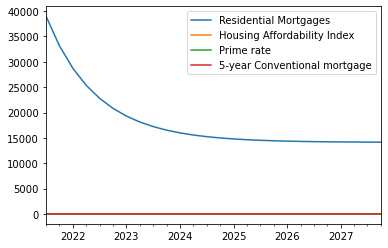

In [53]:
res.plot()

In [54]:
df.head()

Housing Affordability Index  Prime rate  \
1990-06-30                        0.527   14.634615   
1990-09-30                        0.494   14.480769   
1990-12-31                        0.467   13.519231   
1991-03-31                        0.434   11.826923   
1991-06-30                        0.434   10.173077   

            5-year Conventional mortgage  
1990-06-30                     14.096154  
1990-09-30                     13.769231  
1990-12-31                     12.980769  
1991-03-31                     11.865385  
1991-06-30                     11.269231

## Visualization: plot forecast vs. actuals

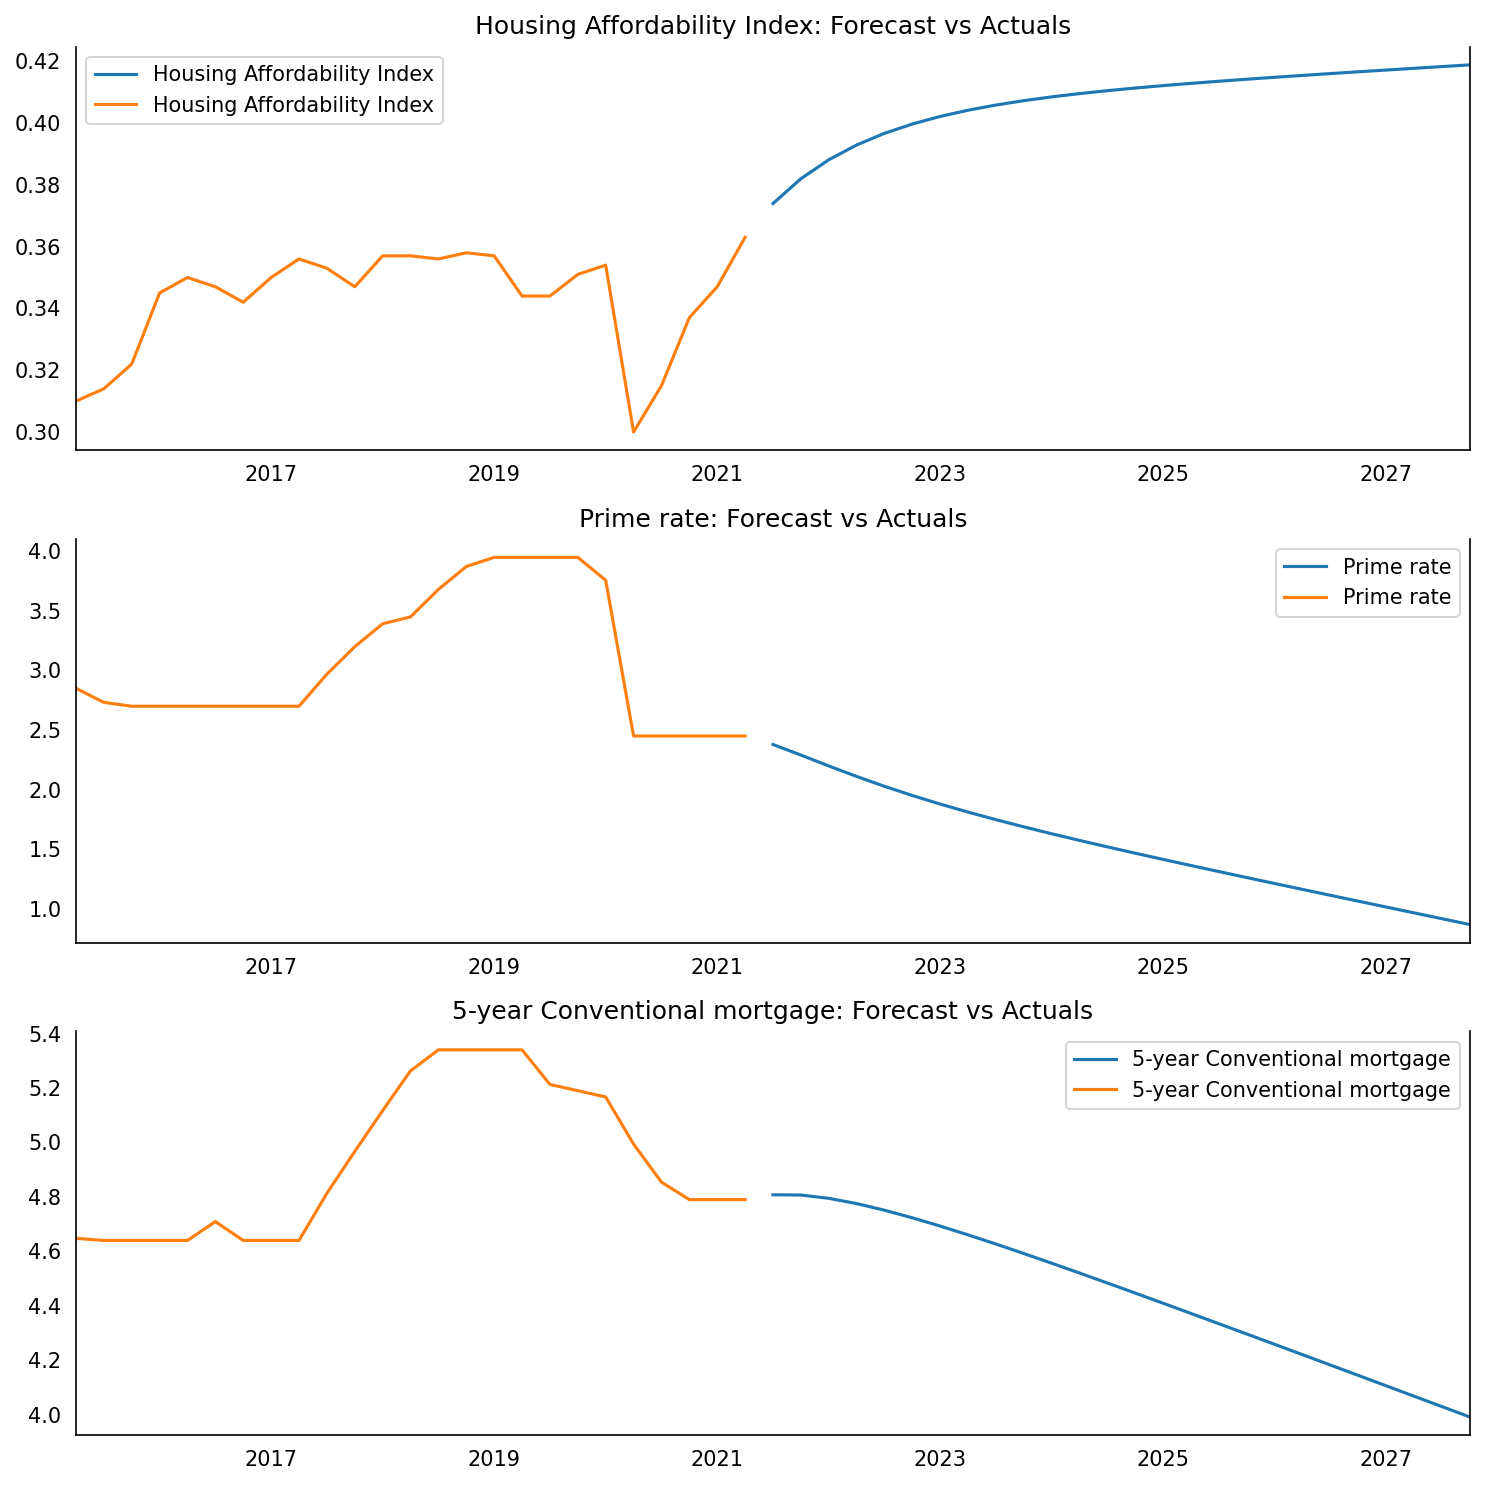

In [55]:

fig, axes = plt.subplots(nrows=int(len(df.columns)), ncols=1, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    res[col].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df[col ][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=10)

plt.tight_layout()

## Take the RMSE Values to forecast the accuracy of the Model

Here we are taking the RMSE values such that we can compare the VARMAX model with the VAR model. 

In [56]:
#Housing Affordability Index
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    test["Housing Affordability Index"],
    res["Housing Affordability Index"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Housing Affordability Index: Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Housing Affordability Index: Out-of-Sample Root Mean Squared Error (RMSE): 0.06909383037554793


In [57]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
     test["Prime rate"],
     res["Prime rate"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Prime rate_1st_inv_diff: Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Prime rate_1st_inv_diff: Out-of-Sample Root Mean Squared Error (RMSE): 7.569127759517671


In [58]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
     test["5-year Conventional mortgage"],
     res["5-year Conventional mortgage"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"5-year Conventional mortgage: Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

5-year Conventional mortgage: Out-of-Sample Root Mean Squared Error (RMSE): 5.851712862436841


## Conclusions & Model Evaluation

| Feature Name | VAR analysis RMSE | VARMAX AutoArima RMSE|
| :- | -: | :-: |
| Residential Mortgages | N/A | N/A 
| Housing Affordability Index  | 0.4445 | 0.06101087219289133 
| Prime rate | 4.0832 | 7.650957319047985 
| 5-year Conventional mortgage | 5.6216 | 4.687757583515452 

We know that if we have a lower RMSE value, then we have a better fit in the model. Here it is a good measure of how accurately the model will be predicting the Housing Trends in Canada. And thus we can say that it is the most important attributes when evaluating a model. 

Therefore, in this case, it is very close between the two models. VARMAX gives a total of about 11, and VAR about 12. Residential Mortgages did not give us a useful RSME in either case, as the differencing did not produce stationary data. Therefore we can compare our two different models on the basis of the other values. Utilizing that framework, the values are slightly better for the VARMAX Auto-ARIMA model, and therefore the VARMAX model can be said to be a better fit. However, it should be noted that these models are statistically very similar in their RMSE values, and therefore the VAR model is not deficient in our analytical toolkit. 
 

References: 
    
https://github.com/Apress/hands-on-time-series-analylsis-python/blob/master/Chapter%204/7.%20VARMA%20with%20Auto%20Arima.ipynb
        
https://learning.oreilly.com/library/view/advanced-forecasting-with/9781484271506/html/508548_1_En_10_Chapter.xhtml
    
https://github.com/xxl4tomxu98/econometrics-gdp-dpi-VAR/blob/main/real-world-VAR.ipynb